# Authored by
This notebook was authored by **Priyadarshini Tamilselvan**

In [1]:
!pip install transformers
!pip install datasets
!pip install peft
!pip install evaluate
!pip install torch
!pip install numpy
!pip install pandas
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, concatenate_datasets
import numpy as np
from evaluate import load
from transformers import pipeline

import torch
from datasets import load_dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    PushToHubCallback
)
import torch.nn as nn


## Reddit Data With Neologism

### Preprocessing the Reddit Dataset

The dataset is preprocessed by dropping rows with missing values in the `body` and `sentiment` columns, converting `body` to strings and `sentiment` to floats, and assigning sentiment labels (`0: Negative`, `1: Neutral`, `2: Positive`) based on predefined score thresholds.


In [4]:
reddit_df = pd.read_csv('the-reddit-dataset-dataset-comments.csv')
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)

def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)

## Untrained Model to Reddit Dataset


### Applying Reddit Dataset with Neologism Words on Untrained DistilBERT

Here I try to evaluate the performance of DistilBERT on the reddit dataset which contains neologisms. On evaluation it can be seen that the accuracy is 42% with an F1 score of 0.32 which is clearly very poor.






In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
results = []

for index, row in reddit_df.iterrows():
    text = row['body']
    true_label = row['label']

    inputs = tokenizer.encode(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        logits = model(inputs).logits

    predictions = torch.argmax(logits, dim=-1).cpu()
    predicted_label = predictions.item()

    results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

predictions_df = pd.DataFrame(results)

In [ ]:
actual_labels = predictions_df['true_label']
predicted_labels = predictions_df['predicted_label']

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Metrics for multi-class classification
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')  # Weighted accounts for label imbalance
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Display metrics
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
 [[  245   211  1266]
 [  887   822 11227]
 [  732   811  9766]]
Accuracy: 0.42
Precision: 0.42
Recall: 0.42
F1 Score: 0.32


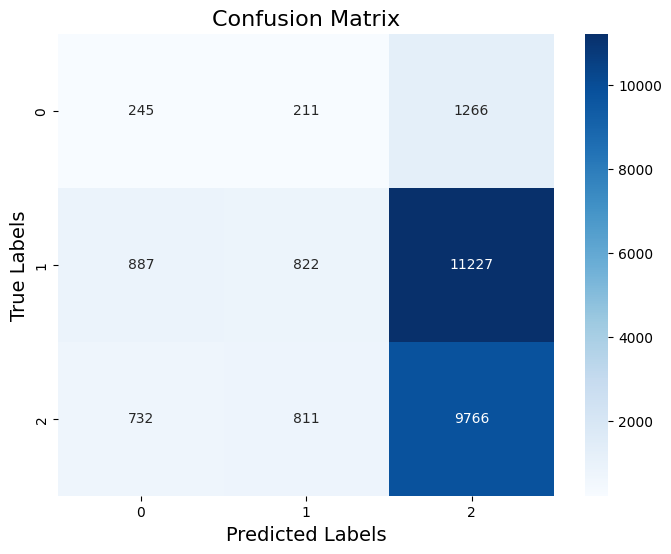

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

## Neologism Dataset for Sentiment Analysis

Loading the generated neologism dataset which contains the neologism words from the Neo Bench Dataset with manually tagged sentiments.

### Preprocessing and Dataset Preparation for Neologism Data

1. **Preprocessing**:
   - Read the `neologism_data.csv` file and ensure `sentence` and `sentiment` columns are converted to strings.
   - Map `sentiment` values to numeric labels (`0: Negative`, `1: Neutral`, `2: Positive`) using a custom function.

2. **Splitting Data**:
   - Split the dataset into training and testing subsets using an 80/20 ratio (`train_test_split`).

3. **Dataset Conversion**:
   - Convert the training and testing data into a HuggingFace `DatasetDict` format for compatibility with DistilBERT's fine-tuning pipeline.

This process ensures that the data is properly formatted and ready for model training and evaluation.




In [6]:
neologism_data = pd.read_csv('neologism_data.csv')
neologism_data['sentence'] = neologism_data['sentence'].astype(str)
neologism_data['sentiment'] = neologism_data['sentiment'].astype(str)

def assign_label(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'neutral':
        return 1
    else:
        return 0

neologism_data['label_n'] = neologism_data['sentiment'].apply(assign_label)

x_train, x_test, y_train, y_test = train_test_split(
    neologism_data['sentence'], neologism_data['label_n'], test_size=0.2, random_state=42
)

dataset = DatasetDict({
    'train': Dataset.from_dict({'label_n': y_train.tolist(), 'sentence': x_train.tolist()}),
    'validation': Dataset.from_dict({'label_n': y_test.tolist(), 'sentence': x_test.tolist()})
})

### LORA Finetuning on base DistilBERT with Neologism Dataset

### Fine-Tuning DistilBERT with LoRA on Neologism Data

1. **Model Setup**:
   - Initialized `distilbert-base-cased` with three labels (`negative`, `neutral`, `positive`).
   - Added special tokens like `[PAD]` if missing and resized token embeddings.

2. **Tokenization**:
   - Implemented a tokenization function to preprocess text inputs by truncating longer sequences and tokenizing sentences.

3. **Metrics Calculation**:
   - Defined a custom `compute_metrics` function to evaluate the model using metrics like accuracy, F1 score, precision, and recall (weighted).

4. **LoRA Configuration**:
   - Applied **Low-Rank Adaptation (LoRA)** to fine-tune only specific layers of the model (`q_lin`) while freezing the others to reduce memory usage and training time.

5. **Training Configuration**:
   - Set training parameters such as learning rate, batch size, number of epochs, and strategies for evaluation and model saving.

6. **Dynamic Metrics Plotting**:
   - Implemented a custom callback to track loss and accuracy at the end of each epoch and plot them post-training.

7. **Model Training**:
   - Fine-tuned the model using the HuggingFace `Trainer` class with:
     - Training and evaluation datasets.
     - Tokenizer and data collator for batching.
     - The `compute_metrics` function for detailed evaluation.
     - A custom metrics plotting callback to visualize performance trends.

This setup leverages LoRA for efficient fine-tuning, provides detailed metrics tracking, and facilitates better understanding of model performance during and after training.

In [12]:
model_checkpoint = 'distilbert-base-cased'

id2label = {0: "negative", 1: "positive", 2: "neutral"}
label2id = {"negative":0, "positive":1, "neutral": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

def tokenize_function(examples):
    text = examples["sentence"]

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )
    tokenized_inputs["labels"] = [label for label in examples["label_n"]]

    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy_eval = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    precision_metric = load("precision")
    recall_metric = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)


    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2195 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

In [13]:
from transformers import Trainer, TrainingArguments

for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

target_modules = ['q_lin']
peft_config = LoraConfig(task_type="SEQ_CLS", r=8, lora_alpha=16, lora_dropout=0.1, target_modules=target_modules)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

lr = 5e-5
batch_size = 4
num_epochs = 3

training_args = TrainingArguments(
    output_dir=model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainable params: 666,627 || all params: 66,450,438 || trainable%: 1.0032


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

class MetricsPlotCallback(TrainerCallback):
    def __init__(self):
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.epoch_loss.append(logs.get("loss"))
            self.epoch_accuracy.append(logs.get("eval_accuracy"))

    def on_train_end(self, args, state, control, **kwargs):
        # Plot metrics at the end of training
        epochs = range(1, len(self.epoch_loss) + 1)

# Add the callback to the trainer
metrics_callback = MetricsPlotCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


<ipython-input-14-7cab0b9526d1>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.792900,0.553188,0.806922,0.780015,0.772458,0.806922
2,0.511400,0.477733,0.821494,0.796015,0.776662,0.821494
3,0.461300,0.465187,0.817851,0.793173,0.770149,0.817851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1647, training_loss=0.5760341567854195, metrics={'train_runtime': 49.437, 'train_samples_per_second': 133.2, 'train_steps_per_second': 33.315, 'total_flos': 56024757605124.0, 'train_loss': 0.5760341567854195, 'epoch': 3.0})



### Observing Performance Drop After Fine-Tuning DistilBERT

During fine-tuning with the neologism dataset, the following performance metrics were observed to decline due to overfitting:

- **Accuracy**: 0.42 → 0.36
- **Precision**: 0.42 → 0.55
- **Recall**: 0.42 → 0.36
- **F1 Score**: 0.32 → 0.29

**Small Dataset Size**: Limited training data might lead the model to memorize patterns even with just 3 epochs instead of generalizing well to unseen data.

In [ ]:
import torch
import pandas as pd

results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for index, row in reddit_df.iterrows():
    text = row['body']
    true_label = row['label']

    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    logits = model(inputs).logits

    predictions = torch.max(logits, 1).indices

    predicted_label = id2label[predictions.tolist()[0]]

    results.append({
        'text': text,
        'true_label': true_label,
        'predicted_label': predicted_label
    })

predictions_df_new = pd.DataFrame(results)


In [ ]:
import torch
import pandas as pd

results = []

model.to('cpu')

for index, row in reddit_df.iterrows():
    text = row['body']
    true_label = row['label']

    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cpu")
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    predicted_label = id2label[predictions.tolist()[0]]
    results.append({
        'text': text,
        'true_label': true_label,
        'predicted_label': predicted_label
    })

predictions_df_new = pd.DataFrame(results)

Confusion Matrix:
 [[1493    5  224]
 [7439   98 5399]
 [3609   62 7638]]
Accuracy: 0.36
Precision: 0.55
Recall: 0.36
F1 Score: 0.29


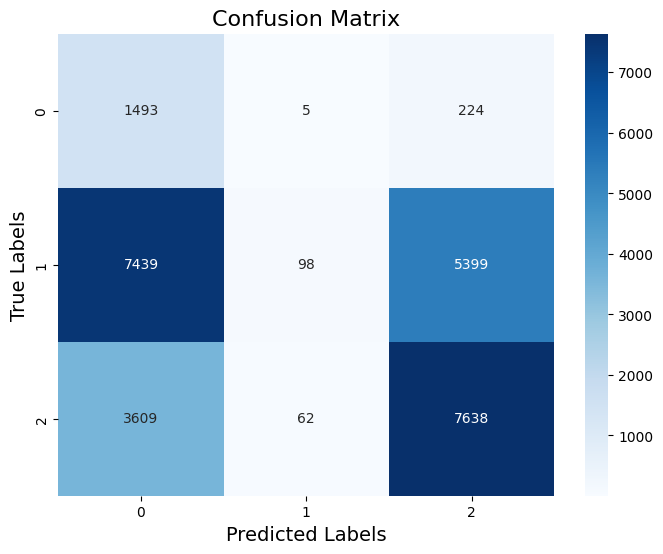

In [ ]:
actual_labels = predictions_df_new['true_label']
predicted_labels = predictions_df_new['predicted_label']

cm = confusion_matrix(actual_labels, predicted_labels)


accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')


print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

## Task Specific  - Finetuning

### Fine-Tuning DistilBERT with Twitter and Neologism Datasets for Sentiment Analysis

1. **Dataset Preparation**:
   - **Twitter Data**:
     - Subset of the Twitter dataset created using `shuffle` and `select` functions to include 26,632 training and 4,000 testing examples.
     - Gold sentiment labels mapped to three categories (`0: Negative`, `1: Neutral`, `2: Positive`) using `label2id`.
   - **Neologism Data**:
     - Tokenized with similar preprocessing steps, retaining original labels (`0: Negative`, `1: Neutral`, `2: Positive`).

2. **Dataset Concatenation**:
   - Combined tokenized Twitter and Neologism datasets to form an enriched training and testing dataset.

3. **Data Collator**:
   - Used a `DataCollatorWithPadding` for dynamic padding during batching to optimize memory usage.

4. **Model Configuration**:
   - Initialized `distilbert-base-uncased` with three output labels for sequence classification.

5. **Metrics Computation**:
   - Customized evaluation metrics for accuracy, F1 score, precision, and recall using HuggingFace's `evaluate` library.

6. **Training Configuration**:
   - Specified hyperparameters:
     - Learning rate: `2e-5`.
     - Batch size: `8`.
     - Weight decay: `0.01`.
     - Number of epochs: `5`.
   - Model checkpoint saving strategy set to "epoch."

7. **Hugging Face Integration**:
   - Logged in to Hugging Face Hub to push the fine-tuned model and training repository for public sharing.

8. **Training and Evaluation**:
   - Used HuggingFace `Trainer` for streamlined model training and evaluation.
   - Trained model on combined Twitter and Neologism datasets to generalize across domains.

9. **Push to Hub**:
   - Saved and uploaded the fine-tuned model to Hugging Face Hub for easy accessibility and reproducibility.

This approach combines diverse data sources, robust preprocessing, and scalable training to create a sentiment analysis model capable of handling general and domain-specific linguistic nuances.


In [ ]:
twitter = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/623k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26632 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12379 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = twitter["train"].shuffle(seed=42).select([i for i in list(range(26632))])
small_test_dataset = twitter["test"].shuffle(seed=42).select([i for i in list(range(4000))])

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

label2id={"0":0, "1":0,"2":1,"3":2,"4":2}
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs["labels"] = [label2id[str(label)] for label in examples["gold_label"]]
    return tokenized_inputs


tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

def preprocess_function_neo(examples):
    tokenized_inputs = tokenizer(examples['sentence'], padding=True, truncation=True, max_length=128)
    tokenized_inputs["labels"] = [label for label in examples["label_n"]]
    return tokenized_inputs

tokenized_neo = dataset.map(preprocess_function_neo, batched=True)
tokenized_train = concatenate_datasets([tokenized_train, tokenized_neo['train']])
tokenized_test = concatenate_datasets([tokenized_train, tokenized_neo['validation']])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/26632 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2195 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    precision_metric = load("precision")
    recall_metric = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)


    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-neologisms-distilbert"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   num_train_epochs=5,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-12-bd7d67100301>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.828800
1000,0.729000
1500,0.718200
2000,0.691400
2500,0.672500
3000,0.658200
3500,0.653600
4000,0.545200
4500,0.512700
5000,0.501100


TrainOutput(global_step=18020, training_loss=0.4003153723167394, metrics={'train_runtime': 1878.3293, 'train_samples_per_second': 76.736, 'train_steps_per_second': 9.594, 'total_flos': 4773382251298560.0, 'train_loss': 0.4003153723167394, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.09577986598014832,
 'eval_accuracy': 0.9780773420479303,
 'eval_f1': 0.9780710458658195,
 'eval_precision': 0.9780757375550224,
 'eval_recall': 0.9780773420479303,
 'eval_runtime': 102.6688,
 'eval_samples_per_second': 286.124,
 'eval_steps_per_second': 35.765,
 'epoch': 5.0}

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1732932122.9ff637910a45.1121.1:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

events.out.tfevents.1732930131.9ff637910a45.1121.0:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert/commit/deb91a3f6ddecfb2ce52d8ac9b4c5fe07192325a', commit_message='End of training', commit_description='', oid='deb91a3f6ddecfb2ce52d8ac9b4c5fe07192325a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert'), pr_revision=None, pr_num=None)

### Performance evaluation of Task Based Finetuning on Reddit Dataset

In [ ]:
sentiment_model = pipeline(model="PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.8035035729408264},
 {'label': 'LABEL_1', 'score': 0.9858502745628357},
 {'label': 'LABEL_2', 'score': 0.9920921921730042},
 {'label': 'LABEL_2', 'score': 0.8547481894493103},
 {'label': 'LABEL_2', 'score': 0.9995754361152649}]

In [ ]:
reddit_df["sentiment_pred"] = reddit_df["body"].apply(
    lambda x: sentiment_model(x, truncation=True, max_length=512, padding=True)[0]["label"]
)
updated_reddit_data = reddit_df
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_0', 0)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_1', 1)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_2', 2)

In [ ]:
actual_labels = updated_reddit_data['sentiment_pred']
predicted_labels = updated_reddit_data['label']

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Metrics for multi-class classification
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')  # Weighted accounts for label imbalance
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Display metrics
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
 [[ 1154  3784  1279]
 [ 1229 18302  8001]
 [   80  5204  8337]]
Accuracy: 0.59
Precision: 0.59
Recall: 0.59
F1 Score: 0.58


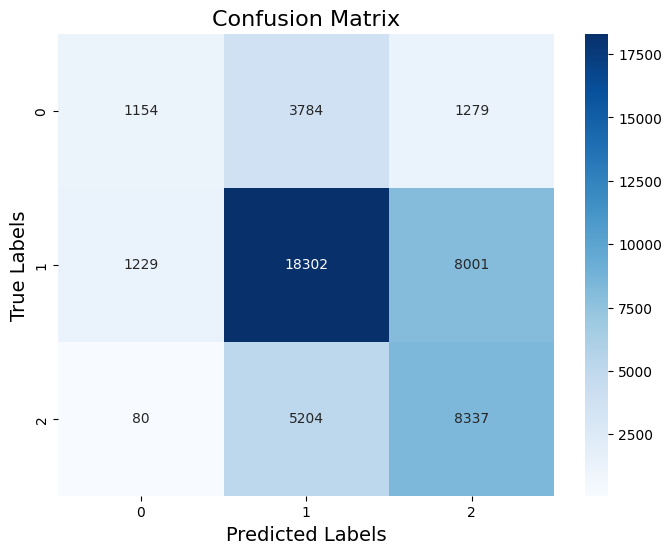

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

## DORA (Domain-Specific Robust Adaptation) Fine Tuning
**DORA** is a domain adaptation method aimed at improving the performance of pre-trained models like DistilBERT when they are applied to domain-specific tasks. DORA addresses **language drift** that occurs when models encounter neologisms and helps them better understand domain-specific patterns.

### What Does DORA Do?
- **Enhances robustness:** Helps the model generalize by focusing on domain-specific features, reducing overfitting.
- **Domain-focused learning:** Adapts the model's attention mechanism to handle the unique linguistic features of the domain, such as slang or new words that were not seen during pre-training.


In [ ]:
dataset = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert", num_labels=3)

label2id={"0":0, "1":0,"2":1,"3":2,"4":2}
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)
    tokenized_inputs["labels"] = [label2id[str(label)] for label in examples["gold_label"]]
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)

class DoRALoss(nn.Module):
    def __init__(self, lam=0.1):
        super(DoRALoss, self).__init__()
        self.lam = lam

    def forward(self, original_loss, model_output, target_domain_features):
        domain_reg_loss = torch.mean((model_output.logits - target_domain_features) ** 2)
        return original_loss + self.lam * domain_reg_loss

dora_loss = DoRALoss(lam=0.1)

def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    precision_metric = load("precision")
    recall_metric = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)


    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

README.md:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/623k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26632 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12379 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/26632 [00:00<?, ? examples/s]

Map:   0%|          | 0/12379 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
repo_name = "finetuning-sentiment-model-neologisms-distilbert-dora"

training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    push_to_hub=False,
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-f39f6a99d849>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.361600,1.219116,0.596750,0.601081,0.609296,0.596750
2,0.184900,2.191490,0.569750,0.579208,0.613289,0.569750
3,0.062000,2.774290,0.579250,0.587325,0.614985,0.579250


TrainOutput(global_step=4995, training_loss=0.1786236017435282, metrics={'train_runtime': 939.327, 'train_samples_per_second': 85.057, 'train_steps_per_second': 5.318, 'total_flos': 2645951006693376.0, 'train_loss': 0.1786236017435282, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.2191158533096313,
 'eval_accuracy': 0.59675,
 'eval_f1': 0.6010807398620807,
 'eval_precision': 0.6092960233490942,
 'eval_recall': 0.59675,
 'eval_runtime': 16.5635,
 'eval_samples_per_second': 241.495,
 'eval_steps_per_second': 15.093,
 'epoch': 3.0}

In [ ]:
model.save_pretrained("./distilbert-dora-super-tweeteval")
tokenizer.save_pretrained("./distilbert-dora-super-tweeteval")

('./distilbert-dora-super-tweeteval/tokenizer_config.json',
 './distilbert-dora-super-tweeteval/special_tokens_map.json',
 './distilbert-dora-super-tweeteval/vocab.txt',
 './distilbert-dora-super-tweeteval/added_tokens.json')

In [ ]:
!zip -r ./distilbert-dora-super-tweeteval.zip ./distilbert-dora-super-tweeteval

In [ ]:
from google.colab import files
files.download('./distilbert-dora-super-tweeteval.zip')

### DORA Performance Evaluation on Reddit Dataset

In [ ]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="./distilbert-dora-super-tweeteval",
    tokenizer="./distilbert-dora-super-tweeteval",
    device=0
)

In [ ]:
reddit_df["sentiment_pred"] = reddit_df["body"].apply(
    lambda x: sentiment_model(x, truncation=True, max_length=512, padding=True)[0]["label"]
)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
updated_reddit_data = reddit_df
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_0', 0)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_1', 1)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_2', 2)

<ipython-input-36-f25222bcb802>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_2', 2)


In [ ]:
actual_labels = updated_reddit_data['sentiment_pred']
predicted_labels = updated_reddit_data['label']

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Metrics for multi-class classification
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')  # Weighted accounts for label imbalance
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Display metrics
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
 [[ 1098  2863  1018]
 [ 1238 18159  6493]
 [  127  6268 10106]]
Accuracy: 0.62
Precision: 0.61
Recall: 0.62
F1 Score: 0.61


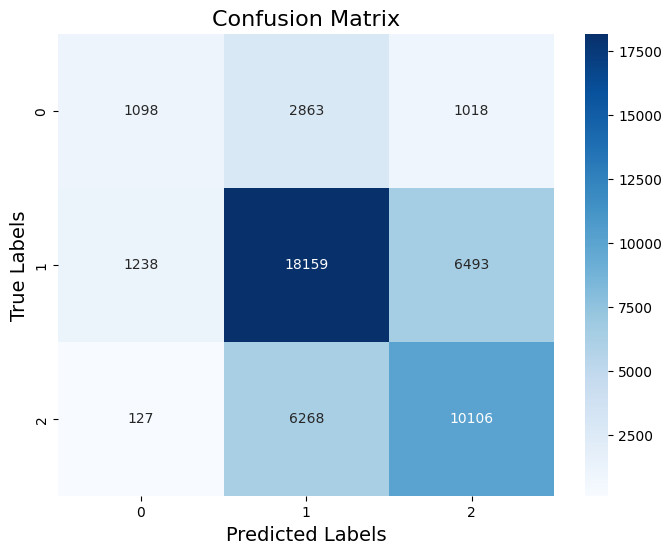

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# LoRA Fine-Tuning for Sentiment Analysis

**LoRA** is applied on the sentiment-analysis fine-tuned **DistilBERT** model. By leveraging LoRA, I efficiently adapt the model with minimal trainable parameters while achieving high performance on both **Twitter** and **neologism datasets**.

---
**LoRA Configuration**:
   - LoRA parameters:
     - `r=8` (low-rank dimension)
     - `lora_alpha=16` (scaling factor)
     - `lora_dropout=0.1` (regularization).
   - Applied on specific model layers (`q_lin`).

**Training Setup**:
   - Learning rate: `5e-5`
   - Epochs: `3`
   - Batch size: `4`
   - Optimized for task-specific layers while freezing the rest of the model.


## Benefits of LoRA
- **Efficiency**: Reduces trainable parameters significantly by using low-rank decomposition.
- **Adaptability**: Fine-tunes models for domain-specific tasks without retraining the entire architecture.
- **Performance**: Maintains comparable or better accuracy while mitigating overfitting.

In [ ]:
twitter = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")

small_train_dataset = twitter["train"].shuffle(seed=42).select([i for i in list(range(26632))])
small_test_dataset = twitter["test"].shuffle(seed=42).select([i for i in list(range(4000))])

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

label2id={"0":0, "1":0,"2":1,"3":2,"4":2}
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs["labels"] = [label2id[str(label)] for label in examples["gold_label"]]
    return tokenized_inputs


tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

def preprocess_function_neo(examples):
    tokenized_inputs = tokenizer(examples['sentence'], padding=True, truncation=True, max_length=128)
    tokenized_inputs["labels"] = [label for label in examples["label_n"]]
    return tokenized_inputs

tokenized_neo = dataset.map(preprocess_function_neo, batched=True)
tokenized_train = concatenate_datasets([tokenized_train, tokenized_neo['train']])
tokenized_test = concatenate_datasets([tokenized_train, tokenized_neo['validation']])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert", num_labels=3)  # Sentiment (positive, negative, neutral)

def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    precision_metric = load("precision")
    recall_metric = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)


    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2195 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

target_modules = ['q_lin']
peft_config = LoraConfig(task_type="SEQ_CLS", r=8, lora_alpha=16, lora_dropout=0.1, target_modules=target_modules)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

lr = 5e-5
batch_size = 4
num_epochs = 3

repo_name = "finetuning-sentiment-model-neologisms-distilbert-lora"
training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainable params: 666,627 || all params: 67,622,406 || trainable%: 0.9858


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

class MetricsPlotCallback(TrainerCallback):
    def __init__(self):
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.epoch_loss.append(logs.get("loss"))
            self.epoch_accuracy.append(logs.get("eval_accuracy"))

    def on_train_end(self, args, state, control, **kwargs):
        # Plot metrics at the end of training
        epochs = range(1, len(self.epoch_loss) + 1)

# Add the callback to the trainer
metrics_callback = MetricsPlotCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]  # Add the callback here
)

# Train the model
trainer.train()


<ipython-input-54-0240dd3e09af>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.139600,0.089638,0.979133,0.979130,0.979133,0.979133
2,0.153700,0.091901,0.979099,0.979093,0.979100,0.979099
3,0.160700,0.087894,0.979337,0.979331,0.979338,0.979337


TrainOutput(global_step=21621, training_loss=0.1351445591817494, metrics={'train_runtime': 1085.5125, 'train_samples_per_second': 79.668, 'train_steps_per_second': 19.918, 'total_flos': 2908220914697472.0, 'train_loss': 0.1351445591817494, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.08789441734552383,
 'eval_accuracy': 0.9793368736383442,
 'eval_f1': 0.9793313364632528,
 'eval_precision': 0.9793380041891127,
 'eval_recall': 0.9793368736383442,
 'eval_runtime': 117.6898,
 'eval_samples_per_second': 249.605,
 'eval_steps_per_second': 62.401,
 'epoch': 3.0}

In [ ]:
model.save_pretrained("./distilbert-lora-super-tweeteval")
tokenizer.save_pretrained("./distilbert-lora-super-tweeteval")

('./distilbert-lora-super-tweeteval/tokenizer_config.json',
 './distilbert-lora-super-tweeteval/special_tokens_map.json',
 './distilbert-lora-super-tweeteval/vocab.txt',
 './distilbert-lora-super-tweeteval/added_tokens.json',
 './distilbert-lora-super-tweeteval/tokenizer.json')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # Get the predicted class index
    return prediction

# Apply the function to the DataFrame
reddit_df["sentiment_pred"] = reddit_df["body"].apply(lambda x: predict_sentiment(x))

In [ ]:
updated_reddit_data = reddit_df
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_0', 0)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_1', 1)
updated_reddit_data['sentiment_pred'] = updated_reddit_data['sentiment_pred'].replace('LABEL_2', 2)

In [29]:
actual_labels = updated_reddit_data['sentiment_pred']
predicted_labels = updated_reddit_data['label']

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Metrics for multi-class classification
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')  # Weighted accounts for label imbalance
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.74
Precision: 0.81
Recall: 0.80
F1 Score: 0.78


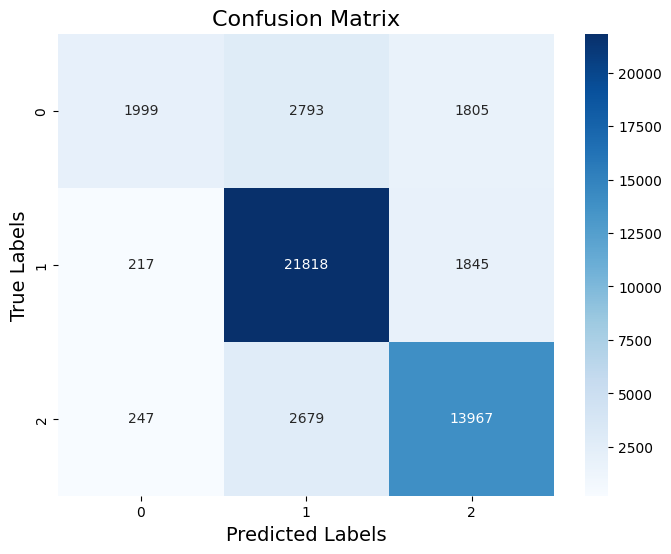

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

## Final Model Performance on Twitter Dataset with Neologisms

The model with the greatest accuracy so far is the LoRA finetuned on sentiment analysis task DistilBERT. Using that for the testing the twitter dataset with neologism words

In [15]:
sentiment_model = pipeline(model="PriyadarshiniTamilselvan/finetuning-sentiment-model-neologisms-distilbert")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
twitter = pd.read_csv('all_sampled_twitter.csv')

In [17]:
twitter

,text,label
0,"""@mattduss @chrislhayes if ISIS does gain a fo...",0
1,"""Sad news! 150 people shot, drowned in Yobe ri...",0
2,@StephenNolan they all served and died under t...,0
3,Rousey vs. Holm may be the biggest waste of a ...,0
4,@user Amy Schumer is the stereotypical 1st wor...,0
...,...,...
8739,The city experienced a complete blackout after...,0
8740,"After the power outage, the city experienced a...",0
8741,The unexpected blackout plunged the city into ...,0
8742,The company's sudden mobilization of resources...,0


In [19]:
twitter["pred"] = twitter["text"].apply(
    lambda x: sentiment_model(x, truncation=True, max_length=512, padding=True)[0]["label"]
)

In [22]:
updated_twitter = twitter
updated_twitter['pred'] = updated_twitter['pred'].replace('LABEL_0', 0)
updated_twitter['pred'] = updated_twitter['pred'].replace('LABEL_1', 1)
updated_twitter['pred'] = updated_twitter['pred'].replace('LABEL_2', 2)

<ipython-input-22-bc41ccf9e8a4>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  updated_twitter['pred'] = updated_twitter['pred'].replace('LABEL_2', 2)


In [27]:
actual_labels = twitter['pred']
predicted_labels = twitter['label']

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Metrics for multi-class classification
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')  # Weighted accounts for label imbalance
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Display metrics
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
 [[2858   55   29]
 [ 495 1777  189]
 [ 137  315 2889]]
Accuracy: 0.86
Precision: 0.81
Recall: 0.89
F1 Score: 0.82


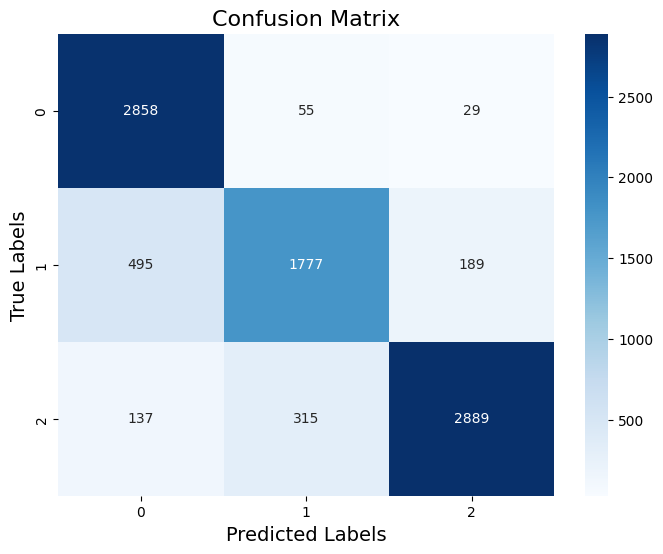

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(actual_labels), yticklabels=unique_labels(actual_labels))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()